# Problem Set 3 - Linear Regression, Logistic Regression, and Naive Bayes
## CSCI 5622 - Spring 2023
***
**Name**: Peter Rock 
***

This assignment is due on Canvas by **11:59PM on March 8**.

Submit only this Jupyter notebook to Canvas with the name format `PS3_<yourname>.ipynb`. Do not compress it using tar, rar, zip, etc.
Your solutions to analysis questions should be done in Markdown directly below the associated question. You can add a write-up markdown cell if it wasn't provided.

Remember that you are encouraged to discuss the problems with your classmates and instructors, 
but **you must write all code and solutions on your own**, and list any people or sources consulted.
The only exception to this rule is that you may copy code directly from your own solution to previous homeworks.
***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import data
%matplotlib inline

## Problem 1: Linear Regression (28 points)
For this problem we will be working with data on the compressive strength of concrete. The compressive strength of this ubiquitous material is a function of its age and ingredients. We will implement linear regression models to predict the compressive strength (in megapascals) from the following features:

| Feature | About |
| --- | --- |
| Cement | component 1, kg in 1 m^3 mixture  |
| Blast Furnace Slag | component 2, kg in 1 m^3 mixture  |
| Fly Ash | component 3, kg in 1 m^3 mixture  |
| Water | component 4, kg in 1 m^3 mixture  |
| Superplasticizer | component 5, kg in 1 m^3 mixture |
| Coarse Aggregate | component 6, kg in 1 m^3 mixture |
| Fine Aggregate | component 7, kg in 1 m^3 mixture |
| Age | component 8, days  |

First, we want to scale the strengths to the interval $[0, 1]$ using `MinMaxScaler`. Given an features matrix $X$, the scaling works as follows:
\begin{align}
    X  \leftarrow \frac{X-min(X)}{max(X) - min(X)}
\end{align}

this is performed as a column-wise operation (column = feature).

As usual, we compute $min(X)$ and $max(X)$ on the training set.

- 1.1.a **[2 points]** Complete `MinMaxScaler.fit` to compute and save the feature-wise min and max.
- 1.1.b **[1 points]** Complete `MinMaxScaler.transform` to apply the min-max scaling using the computed statistics.

In [2]:
class MinMaxScaler:

    def __init__(self):
        self.min = None
        self.max = None

    def fit(self, X):
        """
        Compute and save the features min and max of shape (num_features,)
        (you can also save them with shape (1, num_features))
        :param X: array of shape (num_samples, num_features)
        :return: fitted scaler
        """
        # Workspace 1.1.a
        #BEGIN 
        self.min = np.zeros(len(X[0])).astype(float)
        self.max = np.zeros(len(X[0])).astype(float)
        # self.min = {}
        # self.max = {}
        
        for i in range(len(X[0])):
            self.min[i] = min(X[:,i])
            self.max[i] = max(X[:,i])
        
        #END
        return self

    def transform(self, X):
        """
        Transform the given samples using the precomputed min and max
        :param X: np.array of shape (num_samples, num_features)
        :return: MinMax scaled X, of shape (num_samples, num_features)
        """
        # Workspace 1.1.b
        #BEGIN
        scale_X = X.astype(float)
        
        for i in range(len(scale_X)):
            for j in range(len(scale_X[0])):
                scale_X[i][j] = (scale_X[i][j] - self.min[j])/(self.max[j] - self.min[j])

        #END
        return scale_X

    def fit_transform(self, X):
        """
        Fit using X and then transform it. Useful when we need to scale jsut once.
        """
        self.fit(X)
        return self.transform(X)

In [3]:
%run -i tests scaler

...
----------------------------------------------------------------------
Ran 3 tests in 0.006s

OK


Testing fit
Testing fit


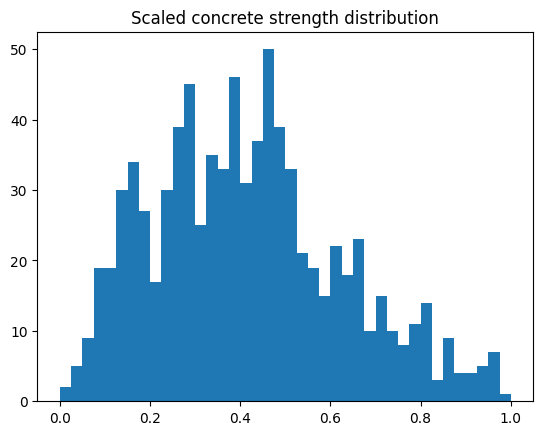

In [4]:
concrete_data = data.Concrete()
minmax_scaler = MinMaxScaler()
# MinMax works on 2-d arrays, so we just need to parse the prices as a single column/feature
# and then squeeze it back to 1-d array
concrete_data.y_train = minmax_scaler.fit_transform(concrete_data.y_train[:, None])[:, 0]
concrete_data.y_test = minmax_scaler.transform(concrete_data.y_test[:, None])[:, 0]
plt.hist(concrete_data.y_train, bins=40)
plt.title("Scaled concrete strength distribution")
plt.show()

We have seen that Ridge regression adds a regularization term to the least square using the L2 norm.
Ridge regression is part of scikit-learn package ([read more](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)), but we will be building our own implementation.
You can test your implementation against scikit's.

The objective of Ridge regression is to minimize:

\begin{align}
\frac{1}{N}\sum_{i=1}^{N} ||y_i-\mathbf{w}^T \mathbf{x_i}-\mathbf{b}||^2 + \alpha||\mathbf{w}||^2
\end{align}

where $\mathbf{w}$ denotes the coefficients vector for the linear regression model,
$\mathbf{b}$ the intercept vector, $\alpha$ the trade-off regularization parameter, and $N$ the number of samples.

Luckily for us, Ridge regression admits a closed form solution for $\mathbf w$ and $\mathbf{b}$.

Let $X$ be the $N\times d$ matrix whose rows are the training samples $(\mathbf{x_i})_{i\leq N}$ and $Y=(y_i)_{i\leq N}$ the target values.

First, we start by centering the features (columns of X) by subtracting the mean of the column to get centered matrix $\tilde{X}$. Then the solution for the minimization is (trust me):

\begin{align}
&\mathbf{w^*} = (\tilde{X}^T\tilde{X}+ \alpha I)^{-1}\tilde{X}^TY \\
&\mathbf{b^*} = \frac{1}{N} \sum_{i}^{i=N} (y_i - \mathbf{w^*}^T \mathbf{x_i})
\end{align}

Note that:
- $\mathbf{w}^*$ and $\mathbf{b}^*$ are the optimal weights and intercepts, respectively.
- The samples in $b^*$ are not centered.
- The predicted targets would be $\hat{y}_i = \mathbf{w^*}^T \mathbf{x_i}+\mathbf{b^*} $
- $\tilde{X}$ is only needed in the `fit` method when we compute $\mathbf{w^*}$ and $\mathbf{b^*}$

A common practice is to scale or normalize (usually normalize) the features before fitting the model. It allows a _fair_ treatment of different features.
You are allowed to use scikit's `StandardScaler` to do the normalization (yes, a thing called scaler is normalizing. Don't @ me, @ sklearn). Do not forget to run the same transformation on the test data before running the prediction.

- 1.2 **[5 points]** Complete the `fit` and `evaluate` methods following the provided descriptions.

In [5]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

class Ridge(object):

    def __init__(self, alpha, normalize=False):
        """
        :param alpha: regularization parameter
        :param normalize: boolean whether to normalize the features or not
        """

        self.alpha = alpha  # our tuning / regularization parameter
        self.coefficients = None  # our weights vector, w (in formulae above)
        self.intercept = None  # our intercept parameter, b (in formulae above)
        self.normalize = normalize  # boolean whether to normalize the features or not
        self.scaler = StandardScaler()  # method by which to normalize the features (depends on self.normalize)

    def fit(self, X, y):
        """
        Fit the ridge model, train it using the provided data
        Calculate the number of non-zero coefficients in the model weights and the norm using np.linalg.norm
        :param X: training features (num_samples, num_features)
        :param y: target values (num_samples)
        :return: tuple (number of non-zeros coefficients of w, norm of w)
        """
        num_nonzero_coefs, coef_norm = 0, 0
        
        # Normalize data with the scaler, if required
        if self.normalize:
            X = self.scaler.fit_transform(X)
        # Center the data
        X_center = X - np.mean(X, 0)
        
        # Workspace 1.2.a
        # TO DO: compute w and b and store them in self.coef_ and self.intercept
        #BEGIN
        
        #X_center is the data that I want to be working with
        w_term_one = np.linalg.inv(np.matmul(X_center.T, X_center) + self.alpha*np.eye(len(X_center[0])))
        w_star = np.matmul(np.matmul(w_term_one, X_center.T), y)
        
        self.coefficients = w_star 
        
        
        b_star = 0
        for i in range(len(X)):
            b_star += y[i] - np.matmul(w_star.T, X[i])
        
        self.intercept = b_star/len(X)
        
        
        num_nonzero_coefs = np.count_nonzero(w_star)
        coef_norm = np.linalg.norm(w_star)
        
        #END
        return num_nonzero_coefs, coef_norm

    def evaluate(self, X, y):
        """
        Compute Root mean square error (RMSE) between the predicted values and the actual values of the test data
        :param X: instances array of shape (num_samples, num_features)
        :param y: the true targets, of shape (num_samples)
        :return: RMSE
        """

        # Workspace 1.2.b
        # TO DO: predict based on the test features and return the root mean squared error
        #BEGIN 
        if self.normalize:
            X = self.scaler.fit_transform(X)
        
        root_mean_squared_error = 0
        
        y_hat = np.matmul(X, self.coefficients) + self.intercept
        
        for i in range(len(y)):
            root_mean_squared_error += (y[i] - y_hat[i])**2
            
        root_mean_squared_error = (root_mean_squared_error/len(y))**(0.5)
        #END
        
        return root_mean_squared_error

In [6]:
# Tests cells, do not remove
# Should run without errors
%run -i tests ridge

....
----------------------------------------------------------------------
Ran 4 tests in 0.007s

OK


<Figure size 640x480 with 0 Axes>

- 1.3 **[3 points]** Produce 3 plots as a function of $\log_{10}(\alpha)$ (logarithmic scale) that compare normalized versus non-normalized Ridge:
    - The number of non-zero coefficients of $\mathbf w$
    - The norm of $\mathbf w$
    - The test RMSE (Root Mean Squared Error)

Use the values of $\alpha$ provided in the cell. What is the best `alpha` for each version of the two models?

To produce multiple plots in the same figure, see the examples [here](https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/subplots_demo.html)

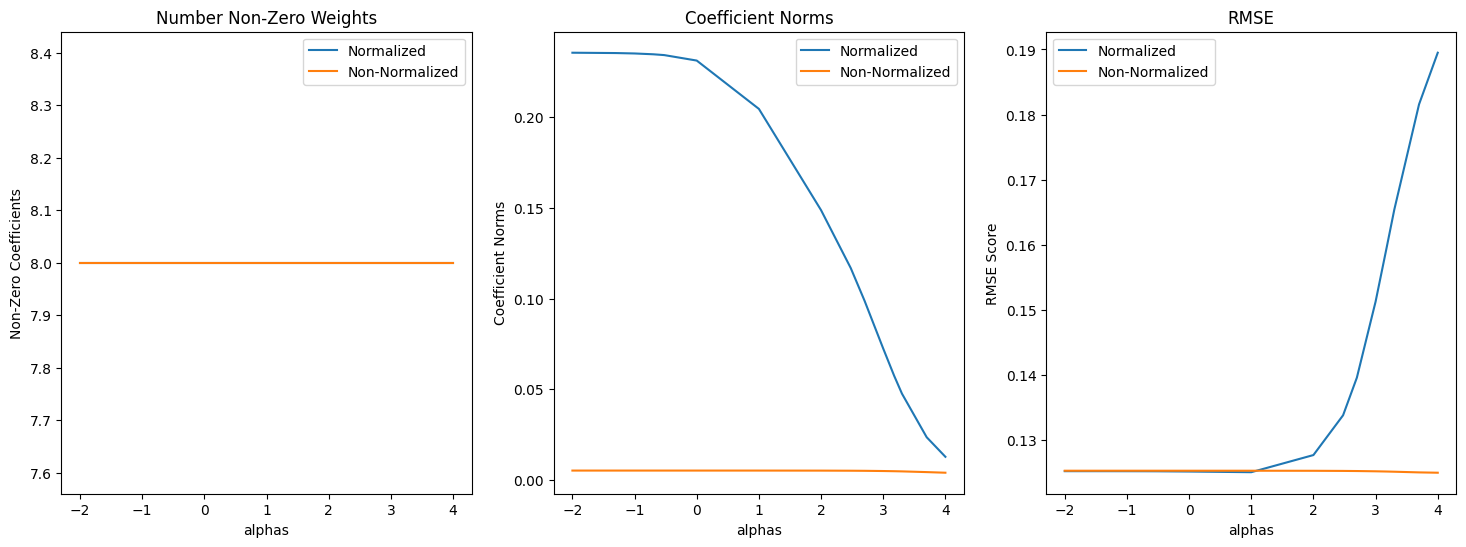

In [7]:
alphas = [0.01, 0.05, 0.1, 0.2, 0.3, 1.0, 10.0, 100.0, 300.0, 500.0, 1e3, 1.5e3, 2e3, 5e3, 1e4]
# Workspace 1.3
#BEGIN 
non_zero_norm = []
norm_norm = []
rmse_norm = []

non_zero_non_norm = []
norm_non_norm = []
rmse_non_norm = []

for alpha in alphas:
    normalized_model = Ridge(alpha, True)
    non_normalized_model = Ridge(alpha, False)
    a, b = normalized_model.fit(concrete_data.X_train, concrete_data.y_train)
    non_zero_norm.append(a)
    norm_norm.append(b)
    rmse_norm.append(normalized_model.evaluate(concrete_data.X_test, concrete_data.y_test))
    a, b = non_normalized_model.fit(concrete_data.X_train, concrete_data.y_train)
    non_zero_non_norm.append(a)
    norm_non_norm.append(b)
    rmse_non_norm.append(non_normalized_model.evaluate(concrete_data.X_test, concrete_data.y_test))


scaled_alphas = np.log10(alphas)
fig, ax = plt.subplots(1, 3,figsize=(18, 6))
ax[0].set_title("Number Non-Zero Weights")
ax[0].plot(scaled_alphas, non_zero_norm, label = "Normalized")
ax[0].plot(scaled_alphas, non_zero_non_norm, label = "Non-Normalized")
ax[0].set(xlabel='alphas', ylabel='Non-Zero Coefficients')
ax[0].legend()

ax[1].set_title("Coefficient Norms")
ax[1].plot(scaled_alphas, norm_norm, label = "Normalized")
ax[1].plot(scaled_alphas, norm_non_norm, label = "Non-Normalized")
ax[1].set(xlabel='alphas', ylabel='Coefficient Norms')
ax[1].legend()

ax[2].set_title("RMSE")
ax[2].plot(scaled_alphas, rmse_norm, label = "Normalized")
ax[2].plot(scaled_alphas, rmse_non_norm, label = "Non-Normalized")
ax[2].set(xlabel='alphas', ylabel='RMSE Score')
ax[2].legend()

    
    
#END

#### Workspace 1.3b
#BEGIN

Based on the RMSE, it looks like the best alpha for the Non-Normalized model is $10^4$ since the line in the RMSE graph slopes slightly downwards. For the Normalized model, on the other hand, it appears that $10$ is the best value of $\alpha$.

#END

Based on the results from previous questions, you should have noticed that the interpretation of Ridge regression is not an easy task.
One way to solve that is to use a regularization that adds _sparsity_ to $\mathbf w$ and excludes less important features.
That's what Lasso regression is about.

Lasso uses $l_1$ norm in the regularization term and minimizes:
\begin{align}
\frac{1}{2N}\sum_i ||y_i-\mathbf{w}^T \mathbf{x}_i -\mathbf{b}||^2 + \alpha||\mathbf{w}||_1
\end{align}

It is part of scikit package ([more details](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html))
and you're free to compare your implementation to scikit's.

Unfortunately, there is no closed form solution for Lasso. Instead, we have powerful algorithms to optimize it.
We will be using lasso-path solver from scikit-learn for our implementation to find $\mathbf w^*$
([see more](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.lasso_path.html#sklearn.linear_model.lasso_path)).
(Note that `lasso_path` takes a list of $\alpha$ in the argument `alphas` and not a scalar.)

Similar to Ridge's, $ \mathbf w^*_{lasso} $ is computed by feeding the centered $\tilde{X}$ to `lasso_path`.
Once $\mathbf w^*$ is found, $\mathbf{b}^*$ has the same formula from Ridge regression.

- 1.4 **[4 points]** Complete the Lasso class in the same way Ridge class was created. (You're allowed to use inheritance for a more concise code, as long as the class has `coefficients` and `intercept` attributes.)

In [8]:
from sklearn.linear_model import lasso_path


class Lasso(object):
    def __init__(self, alpha, normalize=False):
        """
        :param alpha: regularization parameter
        :param normalize: boolean whether to normalize the features or not
        """
        self.alpha = alpha  # our tuning / regularization parameter
        self.coefficients = None  # our weights vector, w (in formulae above)
        self.intercept = None  # our intercept parameter, b (in formulae above)
        self.normalize = normalize  # boolean whether to normalize the features or not
        self.scaler = StandardScaler()  # method by which to normalize the features (depends on self.normalize)

    def fit(self, X, y):
        """
        Fit the lasso model, train it using the provided data
        Calculate the number of non-zero coefficients in the model weights and the norm using np.linalg.norm
        :param X: training features (num_samples, num_features)
        :param y: target values (num_samples)
        :return: tuple (number of non-zeros coefficients of w: scalar, norm of w: scalar)
        """
        
        num_nonzero_coefs, coef_norm = 0, 0
        
        # Normalize data with the scaler, if required
        if self.normalize:
            X = self.scaler.fit_transform(X)
        # Center the data
        X_center = X - np.mean(X, 0)
        
        # Workspace 1.4.a
        # TO DO: compute w and b and store then in self.coef_ and self.intercept
        # TO DO: call lasso_path on the centered features to compute self.coef_
        #BEGIN 
        
        w_star = np.ndarray.flatten(lasso_path(X_center, y, alphas= [self.alpha])[1])
        self.coefficients = w_star
        
        b_star = 0
        for i in range(len(X)):
            b_star += y[i] - np.matmul(w_star.T, X[i])
        
        self.intercept = b_star/len(X)
        
        
        num_nonzero_coefs = np.count_nonzero(w_star)
        coef_norm = np.linalg.norm(w_star)
        #END
        return num_nonzero_coefs, coef_norm

    def evaluate(self, X, y):
        """
        Compute Root mean square error (RMSE) between the predicted values and the actual values  of the test data
        :param X: features array, shape (num_samples, num_features)
        :param y: true targets, shape (num_samples)
        :return: RMSE
        """
        root_mean_squared_error = 0
        # Workspace 1.4.b
        # TO DO: predict based on the test features and return the mean_squared_error
        #BEGIN 
        if self.normalize:
            X = self.scaler.fit_transform(X)
        
        root_mean_squared_error = 0
        
        y_hat = np.matmul(X, self.coefficients) + self.intercept
        
        for i in range(len(y)):
            root_mean_squared_error += (y[i] - y_hat[i])**2
            
        root_mean_squared_error = (root_mean_squared_error/len(y))**(0.5)
        #END
        return root_mean_squared_error

In [9]:
# Tests cell, do not remove
# Test non-normalized Lasso
%run -i tests lasso

....
----------------------------------------------------------------------
Ran 4 tests in 0.009s

OK


<Figure size 640x480 with 0 Axes>

- 1.5 **[3 points]** Produce 3 plots as a function of $\log_{10}(\alpha)$ (logarithmic scale) that compare normalized versus non-normalized Lasso:
    - The number of non-zero coefficients of $\mathbf w$
    - The norm of $\mathbf w$
    - The test RMSE (Root Mean Squared Error)

Use the values of $\alpha$ provided in the cell. What is the best `alpha` for each version of the two models?

Can you get all coefficients of $\mathbf w$ to 0 for the non-normalized Lasso?


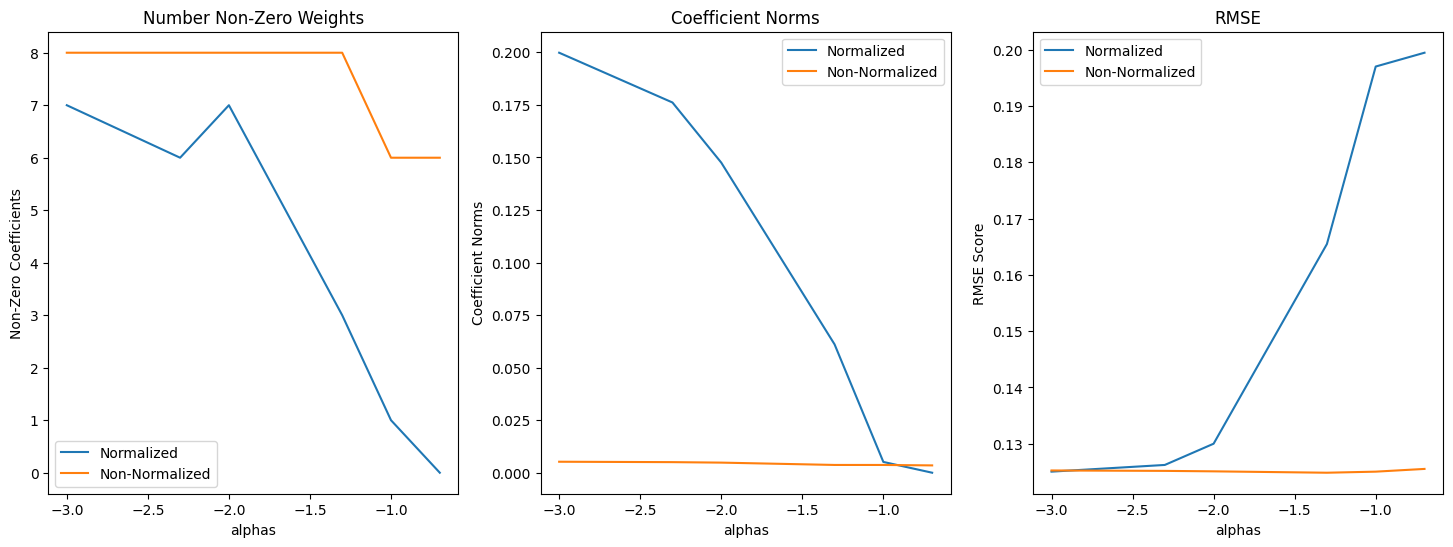

In [10]:
alphas = [1e-3, 5e-3, 0.01, 0.05, 0.1, 0.2]
# Workspace 1.5
#BEGIN 
non_zero_norm = []
norm_norm = []
rmse_norm = []

non_zero_non_norm = []
norm_non_norm = []
rmse_non_norm = []

for alpha in alphas:
    normalized_model = Lasso(alpha, True)
    non_normalized_model = Lasso(alpha, False)
    a, b = normalized_model.fit(concrete_data.X_train, concrete_data.y_train)
    non_zero_norm.append(a)
    norm_norm.append(b)
    rmse_norm.append(normalized_model.evaluate(concrete_data.X_test, concrete_data.y_test))
    a, b = non_normalized_model.fit(concrete_data.X_train, concrete_data.y_train)
    non_zero_non_norm.append(a)
    norm_non_norm.append(b)
    rmse_non_norm.append(non_normalized_model.evaluate(concrete_data.X_test, concrete_data.y_test))


scaled_alphas = np.log10(alphas)
fig, ax = plt.subplots(1, 3,figsize=(18, 6))
ax[0].set_title("Number Non-Zero Weights")
ax[0].plot(scaled_alphas, non_zero_norm, label = "Normalized")
ax[0].plot(scaled_alphas, non_zero_non_norm, label = "Non-Normalized")
ax[0].set(xlabel='alphas', ylabel='Non-Zero Coefficients')
ax[0].legend()

ax[1].set_title("Coefficient Norms")
ax[1].plot(scaled_alphas, norm_norm, label = "Normalized")
ax[1].plot(scaled_alphas, norm_non_norm, label = "Non-Normalized")
ax[1].set(xlabel='alphas', ylabel='Coefficient Norms')
ax[1].legend()

ax[2].set_title("RMSE")
ax[2].plot(scaled_alphas, rmse_norm, label = "Normalized")
ax[2].plot(scaled_alphas, rmse_non_norm, label = "Non-Normalized")
ax[2].set(xlabel='alphas', ylabel='RMSE Score')
ax[2].legend()
#END


#### Workspace 1.5b
%BEGIN

Based on the RMSE, it looks like the best alpha for the Non-Normalized model is $0.1$ (there is a slight dip at that point). For the Normalized model, on the other hand, it appears that $10^{-3}$ is the best value of $\alpha$.

%END

- 1.6 **[3 points]** (Write-up) Compare the two algorithms on the concrete strength dataset: compare the number of non-zero coordinates of Ridge vs Lasso and their RMSE on each dataset. Which type of regression is better? When does normalization improve the RMSE?

#### Workspace 1.6

%BEGIN

Let's begin with the Ridge method. We can see that, regardless of the normalizaiton, the number of non-zero coefficients within the model remained constant at 8. However, the normalization did appear to (moderately) improve the performance of the method for $\alpha = 10$, and appears to not hurt the method for smaller values of $\alpha$.

In the case of the Lasso method, we saw that the number of non-zero coordinated decreased from 8 as the value of $\alpha$ increased, with the normalized method decreasing to zero by the end of the set of $\alpha$ values. Normalization did not help out with improving the RMSE estimate, however, since for almost every value of $\alpha$, we saw the RMSE for the Lasso method increase.

With all this taken together, it appears that Normalization is an appropriate technique for the Ridge regression method, but only for small values of $\alpha$, and is not appropriate for Lasso regression.

%END

Lasso is expected to have higher level of sparsity compared to Ridge. On the other hand, when the number of features is very large
(larger than the sample size), Lasso can struggle at picking the right features.
Elastic Net try to combine both types of regularization to get the best of both worlds by minimizing:

\begin{align}
\frac{1}{2N} \sum_i ||y_i - \mathbf{w}^T\mathbf{x}_i -\mathbf{b}||^2_2 + \alpha\beta||\mathbf{w}||_1 + \frac{\alpha}{2}(1 - \beta)||\mathbf{w}||^2_2
\end{align}

where $\beta\in[0,1]$ is the $l_1$ ratio ($\beta=1$ for Lasso and $\beta=0$ for Ridge).

We'll be using [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) solver from scikit.

- 1.7 **[2 points]** Complete ElasticNet regression class `Elastic` by implementing fit and evaluate methods with the same signature as Lasso and Ridge. (Again, you can use inheritance)

In [11]:
from sklearn.linear_model import ElasticNet


class Elastic(object):
    def __init__(self, alpha, beta=0.5, normalize=False):
        """
        :param alpha: regularization parameter
        :param beta: l1_ratio for ElasticNet
        :param normalize: normalization flag
        """
        self.alpha = alpha
        self.beta = beta
        self.normalize = normalize
        self.scaler = StandardScaler()
        self.coefficients = None
        self.intercept = None
        self._model = ElasticNet(alpha=alpha, l1_ratio=beta)

    def fit(self, X, y):
        """
        fit self._model using the provided data and store the coef and intercept in self.coef_ and self.intercept
        Calculate the number of non-zero coefficients in the model weights and the norm using np.linalg.norm
        :param X: training features (n_samples, n_features)
        :param y: target values (n_samples)
        :return: tuple (number of non-zeros coefficients of w, norm of w)
        """
        num_nonzero_coefs, coef_norm = 0, 0
        
        # Normalize data with the scaler, if required
        if self.normalize:
            X = self.scaler.fit_transform(X)
            
        # Workspace 1.7.a
        # TO DO: Complete Elastic Net
        # TO DO: save w and b in self.coef_ and self.intercept respectively
        #BEGIN 
        
        # User Guide on https://scikit-learn.org/stable/modules/linear_model.html#elastic-net
        self._model.fit(X,y)
        self.coefficients = self._model.coef_
        self.intercept = self._model.intercept_
        
        num_nonzero_coefs = np.count_nonzero(self.coefficients)
        coef_norm = np.linalg.norm(self.coefficients)
        #END
        return num_nonzero_coefs, coef_norm

    def evaluate(self, test_x, test_y):
        """
        Compute Root mean square error (RMSE) between the predicted values and the actual values  of the test data
        :param test_x: test features
        :param test_y: test target
        :return: RMSE
        """

        root_mean_squared_error = 0
        # TO DO: predict based on the test features and return the mean_squared_error
        # Workspace 1.7.b
        #BEGIN 
        if self.normalize:
            test_x = self.scaler.fit_transform(test_x)
        
        root_mean_squared_error = 0
        
        y_hat = np.matmul(test_x, self.coefficients) + self.intercept
        
        for i in range(len(test_y)):
            root_mean_squared_error += (test_y[i] - y_hat[i])**2
            
        root_mean_squared_error = (root_mean_squared_error/len(test_y))**(0.5)
        #END
        return root_mean_squared_error

In [12]:
# Tests cell, do not remove
%run -i tests elastic

....
----------------------------------------------------------------------
Ran 4 tests in 0.009s

OK


<Figure size 640x480 with 0 Axes>

- 1.8 **[2 points]** Produce 3 plots as a function of $\log_{10}(\alpha)$ (logarithmic scale) that compare normalized versus non-normalized `Elastic`:
    - The number of non-zero coefficients of $\mathbf w$
    - The norm of $\mathbf w$
    - The test RMSE (Root Mean Squared Error)

Use the values of $\alpha$ provided in the cell, and $\beta= 0.3$. What is the best `alpha` for each version of the two models? How does it compare to the previous models.


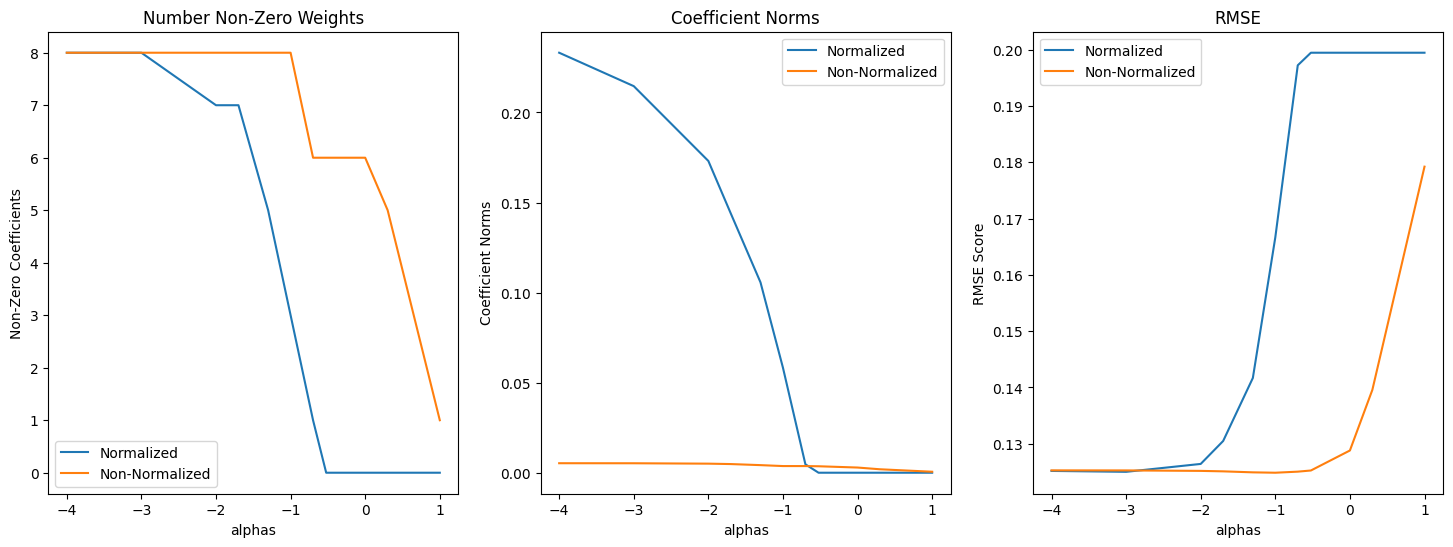

In [13]:
alphas = [1e-4, 1e-3, 1e-2, 0.02, 0.05, 0.1, 0.2, 0.3, 1.0, 2.0, 10.0]
# Workspace 1.2
#BEGIN 
non_zero_norm = []
norm_norm = []
rmse_norm = []

non_zero_non_norm = []
norm_non_norm = []
rmse_non_norm = []

for alpha in alphas:
    normalized_model = Elastic(alpha, normalize=True)
    non_normalized_model = Elastic(alpha, normalize=False)
    a, b = normalized_model.fit(concrete_data.X_train, concrete_data.y_train)
    non_zero_norm.append(a)
    norm_norm.append(b)
    rmse_norm.append(normalized_model.evaluate(concrete_data.X_test, concrete_data.y_test))
    a, b = non_normalized_model.fit(concrete_data.X_train, concrete_data.y_train)
    non_zero_non_norm.append(a)
    norm_non_norm.append(b)
    rmse_non_norm.append(non_normalized_model.evaluate(concrete_data.X_test, concrete_data.y_test))


scaled_alphas = np.log10(alphas)
fig, ax = plt.subplots(1, 3,figsize=(18, 6))
ax[0].set_title("Number Non-Zero Weights")
ax[0].plot(scaled_alphas, non_zero_norm, label = "Normalized")
ax[0].plot(scaled_alphas, non_zero_non_norm, label = "Non-Normalized")
ax[0].set(xlabel='alphas', ylabel='Non-Zero Coefficients')
ax[0].legend()

ax[1].set_title("Coefficient Norms")
ax[1].plot(scaled_alphas, norm_norm, label = "Normalized")
ax[1].plot(scaled_alphas, norm_non_norm, label = "Non-Normalized")
ax[1].set(xlabel='alphas', ylabel='Coefficient Norms')
ax[1].legend()

ax[2].set_title("RMSE")
ax[2].plot(scaled_alphas, rmse_norm, label = "Normalized")
ax[2].plot(scaled_alphas, rmse_non_norm, label = "Non-Normalized")
ax[2].set(xlabel='alphas', ylabel='RMSE Score')
ax[2].legend()
#END

#### Workspace 1.8.b

%BEGIN

It looks like the best value for the Normalized model is $\alpha = 10^{-3}$, and the best value for the Non-Normalized model is  $\alpha = 0.02$. These values appear to be relatively close to the values that we got for the Lasso Model.

%END

1.9 **[3 points]** What are the pros and cons of each of the three types of regressions we have tested?

#### Workspace 1.9

%BEGIN

#### <u>Pros</u>

Ridge:
- Resistant to overfitting
- Lower variance


Lasso: 
- Resistant to overfitting
- Limits contributions of non-important features


Elastic Net:
- Resistant to overfitting
- More sparse than Ridge
- Is able to pick a large number of features compared to Lasso (esp. when the number of data points is small)


#### <u>Cons</u>

Ridge:
- Increases bias 
- Requires tuning of $\alpha$


Lasso: 
- Feature selection is highly biased 
- Can only select as many features as there are data points


Elastic Net:
- Much more expensive to compute than either Ridge or Lasso


%END

***
## Problem 2: Logistic Regression for Binary Classification (30 points)

The second part of this assignment will be dealing with Logistic Regression.
While the name "regression" suggests otherwise, Logistic Regression is actually used for classification.
It's a regression problem because the targets are the continuous likelihoods of the outcomes.

We will use the MNIST digits dataset for this problem.
Let's start with a simple case for binary Logistic Regression: Our class label will be `1` if a sample is an odd number and `0` otherwise.

In [14]:
binary_digits = data.BinaryDigits()

Using the same notations from Problem 1 (this time with discrete targets $y_i$ in {0, 1}), _Logistic Regression_ is about minimizing the **N**egative **L**og **L**ikelihood objective defined as:
\begin{align}
\textrm{NLL}(\mathbf{w}) = -\frac{1}{N}\sum_{i=1}^N \left[y_i \log \sigma({\mathbf{x_i}\mathbf{w}^T}) + (1-y_i)\log(1 - \sigma(\mathbf{x_i}\mathbf{w}^T))\right]
\end{align}

You might be wondering: where is the intercept?
We're including the intercept in $(\mathbf x_i)_i$ since we'll be adding a constant feature $\mathbf x_{i,0} = 1$ to all samples $(\mathbf x_i)_i$.
We will call it the zero-th column and the intercept will be $\mathbf{w}_0$.
This zero-th column will be appended to the training samples in `fit` method and the test samples in `predict` method. $\sigma$ is the sigmoid function seen in class.

The gradient of **NLL** w.r.t $\mathbf{w}$ is:

\begin{align}
\frac{\partial \textrm{NLL}}{\partial \mathbf{w}} = \frac{1}{N} \sum_i \left[\sigma(\mathbf{x}_i\mathbf{w}^T)-y_i)\right]\mathbf{x}_i
\end{align}

- 2.1 **[3 points]** Complete the `sigmoid` function to return the sigmoid values $\sigma({\mathbf{x_i}\mathbf{w}^T})$ given features array. You have to truncate the score ${\mathbf{x_i}\mathbf{w}^T}$ to the interval $[-25, 25]$ to avoid overflow of `np.exp`. *Hint: Pass only x to this function, and perform the matrix multiplication with w inside the function.*


- 2.2 **[3 points]** Finish the `compute_gradient` function to return the derivative of the cost with respect to the weights

- 2.3 **[3 points]** Finish the `batch_update` function so that it performs batch gradient descent using the provided batch data

- 2.4 **[4 points]** Finish the `fit` function so that it performs several training epochs and returns the Recall score on the validation data at the end of each epoch. Initialize $\mathbf{w}$ so that $\mathbf{w}_j = \frac{1}{d}$

- 2.5 **[2 points]** Finish the `predict` method to return the predicted labels (either 0 or 1)


In [15]:
from sklearn.metrics import recall_score

class LogisticRegression:

    def __init__(self, eta=0.1, alpha=0):
        """
        Create a logistic regression classifier
        :param eta: Learning rate
        :param alpha: We will use this parameter later (IN BONUS)
        """

        self.w = None  # uninitialized w
        self.eta = eta  # learning rate
        self.initialized = False # flag used to initialize w only once, it allows calling fit multiple times
        self.alpha = alpha  # regularization / penalty term (USED IN BONUS)

    def sigmoid(self, x, threshold=25.0):
        """

        :param x: features array of shape (num_samples, num_features + 1) (zero-th column appended)
        :param threshold: the truncating threshold for np.exp, default to 25.0
        :return: sigmoid values , of shape (num_samples,)
        """
        # Workspace 2.1
        # TO DO: Complete this function to return the output of applying the sigmoid function to the score
        #BEGIN 
        sigs = []
        
        sign = lambda a: int(a >= 0) - int(a < 0)
        
        for i in range(len(x)):
            z = np.matmul(x[i], self.w.T)
            z = sign(z)*threshold if abs(z) > threshold else z
            sigs.append(1/(1+np.exp(-z)))
        
        return sigs
        #END

    def compute_gradient(self, x, y):
        """
        Return the derivative of the cost w.r.t to the weights. Don't forget to average by batch_size
        :param x:  Feature vector, shape (batch_size, num_features +1), with zero-th column appended
        :param y: real binary class label, shape (batch_size)
        :return: gradient of shape (num_features + 1,)
        """

        # Workspace 2.2
        # TO DO: Finish this function to compute the gradient
        gradient = np.zeros((x.shape[1], ))
        #BEGIN 
        steps = self.sigmoid(x) - y 
        gradient = np.matmul(steps, x)/x.shape[0]
        
        # with bonus
        if self.alpha != 0:
            l2_term = 2 * self.alpha * self.w
            l2_term[0] = 0
            gradient += l2_term
        
        #END
        return gradient

    def batch_update(self, batch_x, batch_y):
        """
        Single self.w update using the batch.
        :param batch_x: array of features (includes the constant feature at column 0), of shape (batch_size, num_features + 1)
        :param batch_y: array of target values, shape (batch_size,)
        :return: nothing
        """

        # Workspace 2.3
        #BEGIN 
        descent = self.eta * self.compute_gradient(batch_x, batch_y)
        self.w -= descent
        #END

    def fit(self, X, y, epochs=1, batch_size=1, validation_X=None, validation_y=None):
        """
        train the LogisticRegression
        :param X: training features, shape (num_samples, num_features)
        :param y: training labels, shape (num_samples,)
        :param epochs: number of epochs, integer
        :param batch_size: size of batch for gradient update, 1 for SGD
        :param validation_X: validation rows, should default to training data if not provided
        :param validation_y: validation labels
        :return: recall score at the end of each epoch on validation data
        """

        if validation_X is None:
            validation_X, validation_y = X, y
        metrics = []
        
        # Prepend constant feature to data
        X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
        
        # initialize weights
        if not self.initialized:
            self.w = np.ones(X.shape[1]) / X.shape[1]
            self.initialized = True
        
        # Workspace  2.4
        # TO DO: Process X to append the zero-th constant column and call self.optimize
        # TO DO: Compute average recall on the validation data at the end of each epoch
        #BEGIN 
        for i in range(epochs):
            self.optimize(X, y, batch_size)
            y_hat = self.predict(validation_X)
            score = recall_score(y_pred=y_hat, y_true= validation_y)
            metrics.append(score)
        #END
        return np.array(metrics)

    def predict(self, X):
        """
        :param X: features array, shape (num_samples, num_features) (without the constant column)
        :return: predicted binary label, shape (num_samples,)
        """
        # Workspace 2.5
        y_hat = np.zeros((X.shape[0],))
        X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)  # We append zero-th column
        #BEGIN 
        #Only returning 0 or 1 here 
        sigs = self.sigmoid(X)
        for i in range(len(X)):
            y_hat[i] = int(sigs[i] >= 0.5)
        #END
        return y_hat

    def optimize(self, X, y, batch_size):
        """
        Perform one epoch batch gradient on shuffled data
        :param X: np.array of shape (num_samples, num_features +1), The training data with zero-th column appended
        :param y: target values of shape (num_samples,)
        :param batch_size: batch_size of the batch_update
        :return: None
        """
        indices = np.random.permutation(len(X))
        for i in range(0, X.shape[0], batch_size):
            batch_x = X[indices[i:i + batch_size]]
            batch_y = y[indices[i:i + batch_size]]
            self.batch_update(batch_x, batch_y)

After completing the class above, loop over the training data and perform batch training with `batch_size=1`(Stochastic Gradient Descent) for 50 epochs, and different values of eta ( see `etas`). Train your model and do the following:

- 2.6 **[5 points]** Plot the recall trend for the different values of eta on the training data (epoch vs recall). (reset random seed for each loop to mitigate the randomness effect)

Use the values provided below

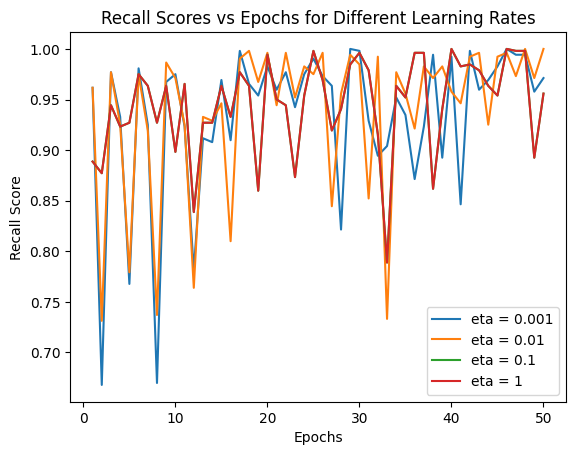

In [16]:
etas = [.001, .01, 0.1, 1]

for eta in etas:
    np.random.seed(2022)  # Reset randomness
    # Workspace 2.6
    #BEGIN 
    classifier = LogisticRegression(eta= eta)
    recall_scores = classifier.fit(binary_digits.X_train, binary_digits.y_train, epochs= 50)
    x_vals = np.arange(1,51)
    plt.plot(x_vals, recall_scores, label=f"eta = {eta}")
    plt.title("Recall Scores vs Epochs for Different Learning Rates")
    plt.xlabel("Epochs")
    plt.ylabel("Recall Score")
    #END
plt.legend()
plt.show()

- 2.7 **[3 points]** Plot the recall trend for the different values of eta on the test data.
(reset random seed for each loop to mitigate the randomness effect)

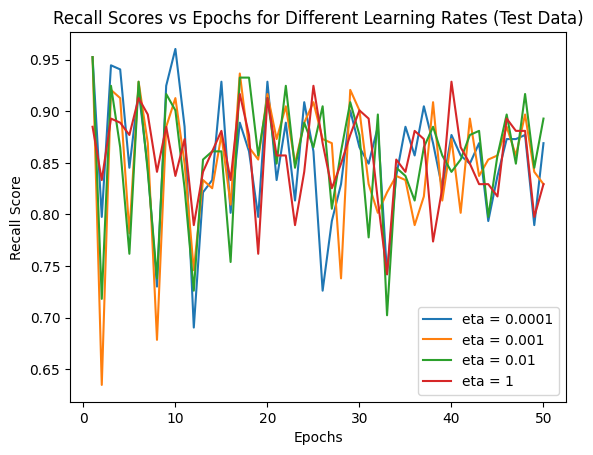

In [17]:
etas = [.0001, .001, .01, 1]

for eta in etas:
    np.random.seed(2022)
    # Workspace 2.7
    #BEGIN 
    classifier = LogisticRegression(eta= eta)
    recall_scores = classifier.fit(X= binary_digits.X_train, y= binary_digits.y_train, epochs= 50,
                                   validation_X= binary_digits.X_test, validation_y= binary_digits.y_test)
    x_vals = np.arange(1,51)
    plt.plot(x_vals, recall_scores, label=f"eta = {eta}")
    plt.title("Recall Scores vs Epochs for Different Learning Rates (Test Data)")
    plt.xlabel("Epochs")
    plt.ylabel("Recall Score")
    #END
plt.legend()
plt.show()

This time we want to analyze the effect of varying the batch size. We fix `eta=0.01` and `epochs=50` and we want to
examine the recall on the test set at the end of the training.

- 2.8 **[4 points]** Produce a plot of the recall on the test data at the end of the training as a function of the batch size. Reset the random generator for each iteration.

Use batch sizes provided below

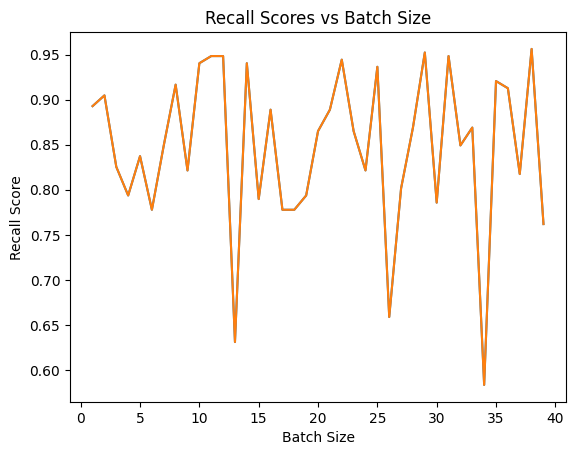

In [18]:
batch_sizes = list(range(1, 40))
recalls = []

for b_size in batch_sizes:
    np.random.seed(2022)
    # Workspace 2.8
    #BEGIN 
    classifier = LogisticRegression(eta= 0.01)
    recall_scores = classifier.fit(X= binary_digits.X_train, 
                                   y= binary_digits.y_train, 
                                   epochs= 50, 
                                   batch_size=b_size,
                                   validation_X= binary_digits.X_test, 
                                   validation_y= binary_digits.y_test)
    recalls.append(recall_scores[-1]) #the score for epochs = 50
    
plt.plot(batch_sizes, recalls)
plt.title("Recall Scores vs Batch Size")
plt.xlabel("Batch Size")
plt.ylabel("Recall Score")
    #END
plt.plot(batch_sizes, recalls)
plt.show()

2.9 **[3 points]** How does the learning rate (eta) and the number of epochs affect the performance of the classifier.

#### Workspace 2.9

%BEGIN

The learning rate effects the speed at which we approach the optimal weights. However, if the learning rate is too large, then the weighted gradient descent we we are employing is likely to shoot past any local optimizer for the model. On the other hand, if we make the learning rate too small, it will take an eternity to find the optimal weights.


As the number of epochs that we are allowed to iterate through increases, so too does the accuracy of the model on the training set since the model "sees" the training set once per epoch. However, like with any statistical model, if we let our classifier see the training data too many times, it can become overfit. If we liken this to studying for an exam, instead of getting an idea of what is on the review guide for the test and then making good guesses based on that knowledge, the model just memorizes the review guide through mere exposure and is unable to adapt to any question on an exam that is not phrased exactly like a review question.

%END

2.10 (**Bonus**) **[4 points]** Since we're done with the binary regression, we will try to add Ridge regularization:
\begin{align}
\textrm{NLL}(\mathbf{w}) = -\frac{1}{N}\sum_{i=1}^N \left[y_i \log \sigma(\mathbf{w}^T{\mathbf{x}_i}) + (1-y_i)\log(1 - \sigma(\mathbf{w}^T\mathbf{x}_i))\right] + \alpha {||\mathbf{w}||^2}_{\geq1}
\end{align}

This is exactly what we will be using the `alpha` parameter in `LogisticRegression` for.
First, write the gradient formula in the cell below and edit your `compute_gradient` to account for the regularization term. Note that the regularization $||\mathbf{w}||^2$ does not apply to the intercept $\mathbf{w}_0$

#### Workspace 2.10

%BEGIN

To find the gradient, we just need to take the derivative of the above expression. This gives us

\begin{align}
\frac{\partial \textrm{NLL}}{\partial \mathbf{w}} = \frac{1}{N} \sum_i \left[\sigma(\mathbf{w}^T\mathbf{x}_i)-y_i)\right]\mathbf{x}_i + 2\alpha\mathbf{w}
\end{align}

(Note the vector $\mathbf{w}$). In the code implementation, we set $w_0 = 0$ to account for the intercept.
%END



## Problem 3: Logistic Regression for Multiclass Classification (24 Points)
***
You will now create a classifier that is commonly referred to as _One Versus All_ Logistic Regression,
where a binary classifier will be trained to identify a single class. The prediction is performed by assigning the label
of the classifier that is most confident in its prediction (the highest score/sigmoid value).

The dataset will be the same one we use in Problem Set 1's KNNClassifier

In [19]:
from sklearn.preprocessing import StandardScaler
digits = data.Digits()
scaler = StandardScaler()
digits.X_train = scaler.fit_transform(digits.X_train)
digits.X_test = scaler.transform(digits.X_test)

- 3.1 **[3 points]** Complete `one_hot_encoding` to transform your integer labels into a set of binary features via one-hot encoding.
You can assume that it's called after `label_to_index` and `index_to_label` have been defined.


- 3.2 **[2 points]** Complete `normalize_data` to normalize your features. You can use `StandardScaler`
- 3.3 **[4 points]** Complete `predict` method to return the predicted label using the scores from each class classifier.
You might be tempted to call `LogisticRegression.predict`, but you need the sigmoid values to determine the most likely label (and hence have to add the zero-th column in OneVersusAll).

- 3.4 **[2 points]** Complete `evaluate` to return the weighted average recall (WAR) on the validation data (use `recall_score`)
- 3.5 **[6 points]** Complete `fit` function to fit all classifiers with their corresponding labels and compute the WAR at the end of each epoch

Reminder: make no assumption about the number of features/classes in the data.

In [20]:
class OneVersusAll(object):

    def __init__(self, eta=0.1, alpha=0):
        self.eta = eta  # Learning Rate
        self.classifiers = []  # Array of LogisticRegression classifiers
        self.alpha = alpha  # regularization / penalty rate (USED IN BONUS)
        self.scaler = StandardScaler()
        self.fitted = False  # Flag to store whether the model is already fitted to avoid fitting scaler more than once

    def one_hot_encoding(self, y):
        """
        Create one-hot encoding of y
        :param y: shape (num_samples,)
        :return: one hot encoding (num_samples, C) where C is the number of classes in the training labels
        """
        one_hot_encode = np.zeros((y.shape[0], len(self.label_to_index)), dtype=int)
        # Workspace 3.1
        # TO DO: Represent the output vector y as a one hot encoding. Create a matrix M of dimensions (n X C)
        # where n = number of samples, and C for number of classes
        # If y[i] = class j, then M[i] is equal to 1 at position j and 0 elsewhere
        #BEGIN 
        for i in range(len(y)):
            one_hot_encode[i][self.label_to_index[y[i]]] = 1
        #END
        return one_hot_encode

    def normalize_data(self, X):
        """
        Fit scaler if it hasn't been done yet and normalize X
        :param X: Raw features, shape (num_samples, num_features)
        :return: Normalized features,  shape (num_samples, num_features)
        """
        # Workspace 3.2
        # TO DO: Normalize the feature values of dataset X, you have to keep track of the mean and variance
        #BEGIN 
        if not self.fitted:
            self.scaler.fit(X)
            self.fitted = True
            
        X = self.scaler.transform(X) # the transform function centers and scales
        #END
        return X

    def predict(self, X):
        """
        The usual predict method
        """
        # Workspace 3.3
        # TO DO: Normalize X, process it and return the predicted label using the scores from classifiers
        #BEGIN 
        X = self.normalize_data(X)
        X = np.concatenate([np.ones((X.shape[0],1)), X], axis= 1)
        
        sigs_mat = np.zeros((len(self.classifiers),len(X)))
        y_hat = []
        for i, classifier in enumerate(self.classifiers):
            sigs_mat[i] = classifier.sigmoid(X)
        
        
        #got a little confused here and got help from Jerry in OH
        for i in range(len(X)):
            y_hat.append(self.index_to_label[np.argmax(sigs_mat[:,i])]) 
        
        return np.array(y_hat)
        #END

    def evaluate(self, test_x, test_y):
        # Workspace 3.4
        #BEGIN 
        y_hat = self.predict(test_x)
        labels = list(self.label_to_index.keys())
        return recall_score(y_pred= y_hat,
                            y_true= test_y,
                            labels= labels, 
                            average= "weighted")
        #END

    def fit(self, X, y, batch_size=1, epochs=10, validation_X=None, validation_y=None):
        """
        Similar to LogisticRegression, but for multiclass case
        :return: metrics, containing WAR score at the end of each epoch on the validation data
        """
        self.label_to_index = dict(zip(np.unique(y), range(len(np.unique(y)))))
        self.index_to_label = {v: k for k, v in self.label_to_index.items()}

        metrics = []
        if validation_X is None:
            validation_X, validation_y = X, y
        # Workspace 3.5
        # TO DO: Compute Weighted Average Recall at the end of each epoch
        # TO DO: Process training data and use it to fit self.classifiers and compute the metrics every epoch
        #BEGIN 
        
        #Train one classifier per class you want to recognize
        for i in range(len(self.index_to_label)):
            self.classifiers.append(LogisticRegression(eta= self.eta, alpha= self.alpha))
        
        X = self.normalize_data(X)
        one_hot_y = self.one_hot_encoding(y)
        
        for i in range(epochs):
            for idx, classifier in enumerate(self.classifiers):
                classifier.fit(X,one_hot_y[:,idx],batch_size = batch_size)
            metrics.append(self.evaluate(validation_X, validation_y))
        #END
        return metrics



- 3.6 **[4 points]** Train `OneVersusAll` for 100 epochs using eta=0.1 and batch_size = 64. In the same figure, plot:
    - The WAR metric on the digits training data at the end of each epoch
    - The WAR metric on the digits test data at the end of each epoch
You should also print the best score on each if the partitions.
You might need to adapt LogisticRegression so that fit method can be called multiple times without losing the weights from previous epoch.

For a fair comparison, call `np.random.seed(42)` before each `fit` to reset the random generator.

87 18


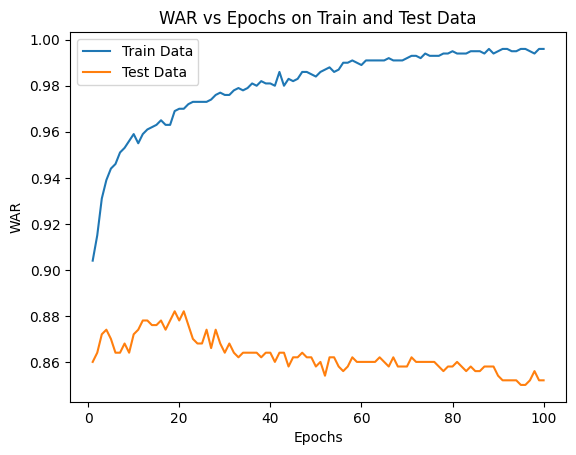

In [21]:
epochs = 100
eta = 0.1
batch_size = 64
# Workspace 3.6
#BEGIN 
np.random.seed(42)
train_classifier = OneVersusAll(eta)
train_score = train_classifier.fit(X= binary_digits.X_train, 
                                   y= binary_digits.y_train, 
                                   batch_size= batch_size,
                                   epochs= epochs)

np.random.seed(42)
test_classifier = OneVersusAll(eta)
test_score = test_classifier.fit(X= binary_digits.X_train, 
                                 y= binary_digits.y_train, 
                                 batch_size= batch_size,
                                 epochs= epochs,
                                 validation_X= binary_digits.X_test,
                                 validation_y= binary_digits.y_test)

best_train_score, best_test_score = np.argmax(train_score), np.argmax(test_score)
print(best_train_score, best_test_score)
plt.title(f"WAR vs Epochs on Train and Test Data")
plt.plot(range(1,epochs+1), train_score, label="Train Data")
plt.plot(range(1,epochs+1), test_score, label="Test Data")
plt.xlabel("Epochs")
plt.ylabel("WAR")
plt.legend()
plt.show()

#END

- 3.7 **[3 points]** Does the WAR improve as we train for more epochs on the two data partitions (train, test)? Why? How does it compare to KNNClassifier? How do you explain the difference?

% Workspace 3.7

%BEGIN

The WAR appears to improve roughly logarithmically on the training data as we train for more epochs, however, on the testing data, it increases mildly before decreasing substantially. This is likely due to overfitting on the training data as the number of epochs gets large. 

In the case of the KNN classifier, we saw something similar. Increasing the number of neighbors increased the accuracy on the training set approximately logarithmically and it decreased the accuracy of the testing set (also approximately approximately logarithmically). However, in the case of the KNN classifier, it was also possible to make the accuracy on the training set 100\% right away by just making the classifier consistent.

%END

- 3.8 **(Bonus)** **[3 points]** Repeat 3.6 and 3.7 using Ridge regularization for the LogisticRegression classifiers with alpha=0.01. How does the regularization affect the performance on train VS test sets?

You have to answer 2.10 before you attempt this question.

68 20


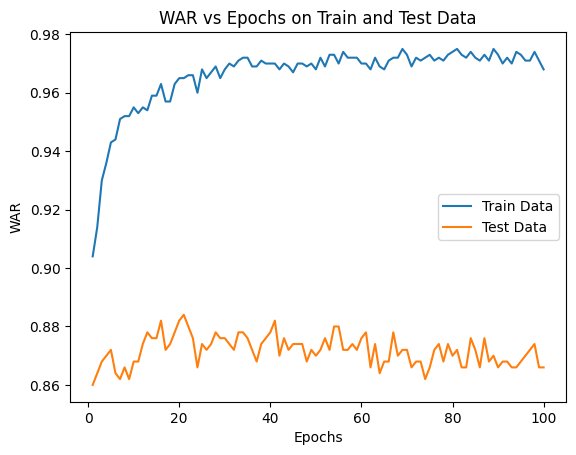

In [22]:
epochs = 100
eta = 0.1
batch_size = 64
alpha = 1e-2
# Workspace 3.8 (code)
#BEGIN 
np.random.seed(42)
train_classifier = OneVersusAll(eta, alpha)
train_score = train_classifier.fit(X= binary_digits.X_train, 
                                   y= binary_digits.y_train, 
                                   batch_size= batch_size,
                                   epochs= epochs)

np.random.seed(42)
test_classifier = OneVersusAll(eta, alpha)
test_score = test_classifier.fit(X= binary_digits.X_train, 
                                 y= binary_digits.y_train, 
                                 batch_size= batch_size,
                                 epochs= epochs,
                                 validation_X= binary_digits.X_test,
                                 validation_y= binary_digits.y_test)

best_train_score, best_test_score = np.argmax(train_score), np.argmax(test_score)
print(best_train_score, best_test_score)
plt.title(f"WAR vs Epochs on Train and Test Data")
plt.plot(range(1,epochs+1), train_score, label="Train Data")
plt.plot(range(1,epochs+1), test_score, label="Test Data")
plt.xlabel("Epochs")
plt.ylabel("WAR")
plt.legend()
plt.show()
#END

#### Workspace 3.8 (write up)

%BEGIN

It looks like the regularization changed the performance of the model for large epochs. Specifically, it seems to have
lowered the ceiling on the WAR for the training data from near 100\% to somewhere around 97\%. However this came with a
significant improvement to the testing data for large epochs. We can see that the accuracy on the testing data now seems
to consistently hover somewhere around 87\% whereas before we started at ~87\% and then slowly declined towards \<85\% 
as the epochs increased.

%END

## Problem 4: Naive Bayes (17 points)
***
Consider the problem of predicting whether your TA will be late to campus in the morning based off the weather, temperature, and whether they biked or took the bus.
The dataset looks like the following:

|Snowing |Raining |Below Freezing |Bike or Bus |Late |
|:------:|:-----------:| :----------:| :----------:|--:|
| Yes | No | Yes | Bus  | Yes |
| No | No | No | Bicycle | No |
| No | Yes | No | Bicycle | Yes |
| No | No | No | Bus | Yes |
| No | No | No | Bicycle | No |
| No | No | Yes | Bicycle | No |
| No | No | Yes | Bicycle | Yes |
| Yes | Yes | Yes | Bus | No |
| No | Yes | No | Bus | Yes |
| No | Yes | No | Bicycle | No |
| No | No | No | Bicycle | No |
| Yes | No | Yes | Bicycle | Yes |


In [23]:
features = np.array([
    [1, 0, 1, 0],
    [0, 0, 0, 1],
    [0, 1, 0, 1],
    [0, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 1],
    [0, 0, 1, 1],
    [1, 1, 1, 0],
    [0, 1, 0, 0],
    [0, 1, 0, 1],
    [0, 0, 0, 1],
    [1, 0, 1, 1]
])
labels = np.array([1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1])

In [24]:
for i in range(4):
    print(np.count_nonzero(labels == features[:,i])/len(labels)*100)

58.333333333333336
50.0
58.333333333333336
33.33333333333333


4.1 [2 points] If we were to use only one binary feature (Snowing, Raining, Below Freezing, Bike or Bus)
then what's the highest accuracy we could achieve? Which feature should we use?

**Workspace 4.2**

#BEGIN

Both "Snowing" and "Below Freezing" give us ~58% accuracy.

#END

## How to implement NaiveBayes
Recall Bayes' Theorem, which states the following:
\begin{align}
P(y | X) = \frac{P(X | y) P(y)}{P(X)}
\end{align}

We refer to $P(y | X)$ as the posterior, $P(X|y)$ as the class-conditional, $P(y)$ as the prior, and $P(X)$ as the evidence.

As seen during the class, given a sample $(x_1, x_2, x_3)$, the naive Bayes classifier should assign the label $y$ that
maximizes:

\begin{align}
\log [p(y) \prod_i p(x_i | y)] = \log p(y) + \sum_{i} \log p(x_i | y)
\end{align}

$p(y)$ and $p(x_i | y)$ are computed using the training set (during `fit` call).

For this, we need two attributes to store
$\log p(y)$ and $\log p(x_i | y)$ for different features $i$.

Let's assume we're working with binary classes $\{0, 1\}$ and all features have discrete supports.
Then we will store our log prior, `classes_log_probability`, as an array of shape `(2,)` that contains:
\begin{bmatrix}
\log p(y=0),\log p(y=1)
\end{bmatrix}.

Here, $p(y=1)$ is just the fraction of the time that y is 1 in the training set.

If feature $i$ has $2$ possible values $\{0, 1\}$, then we want to store our log class-conditional, $\log p(x_i | y)$, as a $ 2 \times 2$ matrix:

\begin{align}
A_i = \begin{bmatrix}
\log p(x_i=0 | y=0) & \log p(x_i=1| y=0)\\
\log p(x_i=0 | y=1) & \log p(x_i=1 | y=1)
\end{bmatrix}
\end{align}


`features_log_likelihood` should then store such matrix for each feature.

We have defined $p(x_i | y)$ as :
\begin{align}
p(x_i | y) = \frac{N_{y,x_i}}{N_y}
\end{align}
where $N_{y,i}$ is the number of instances where $y$ and $x_i$ occur together, and $N_y = \sum_i N_{y,x_i}$.

4.2 [2 points] Complete the method `compute_classes` and store the log prior in `classes_log_probability`

4.3 [5 points] Complete the method `compute_features` by storing the matrices $A_i$ in `self.features_log_likelihood`. We need one matrix for each feature.

4.4  Study the method `joint_log_likelihood`. You will need to use this to complete Naive Bayes. Note that it computes the likelihood quantities
 $[\sum_{i} \log p(x_i | y=0), \sum_{i} \log p(x_i | y=1)]$ for each observation

4.5 [3 points] Complete the `predict` method

In [25]:
class NaiveBayes(object):
    """
    NaiveBayes classifier for binary features and binary labels
    """

    def __init__(self, alpha=0.0):
        self.alpha = alpha
        self.classes_counts = None
        self.classes_log_probability = np.empty((2,))
        self.features_log_likelihood = []  # list of arrays where element i store log p(X[:,i], y)

    def compute_classes(self, y):
        """
        Computes the log prior of binary classes and stores the result in self.classes_log_probability
        :param y: binary labels array, shape (m,)
        """
        # Workspace 4.2
        #BEGIN 
        
        #compute number of occurances of each label
        self.classes_counts = np.bincount(y) # count for class i stored at index i
        
        prob_0 = (self.classes_counts[0] + self.alpha)/(len(y) + 2*self.alpha)
        prob_1 = (self.classes_counts[1] + self.alpha)/(len(y) + 2*self.alpha)
        
        self.classes_log_probability[0] = np.log(prob_0)
        self.classes_log_probability[1] = np.log(prob_1)
        
        # self.classes_log_probability[0] = np.log(1.1)
        # self.classes_log_probability[1] = np.log(1.1)

        #END

    def compute_features(self, X, y):
        """
        Computes the log likelihood matrices for different features and stores them in self.features_log_likelihood
        :param X: data matrix with binary features, shape (n_samples, n_features)
        :param y: binary labels array, shape (n_samples,)
        """
        # Workspace 4.3
        #BEGIN 
        
        for i in range(X.shape[1]):
            feature_counts = np.zeros((2, 2)) 
            for j in range(X.shape[0]):
                feature_counts[y[j], X[j, i]] += 1
            
            # vector[:,None] allows you to divide across rows
            feature_probs = (feature_counts + self.alpha) / (np.sum(feature_counts, axis=1) + 2*self.alpha)[:,None]
            feature_probs = np.array(np.log(feature_probs))
            
            self.features_log_likelihood.append(feature_probs)
        # self.features_log_likelihood = np.array(self.features_log_likelihood)
        #END

    def fit(self, X, y):
        """
        :param X: binary np.array of shape (n_samples, n_features) [values 0 or 1]
        :param y: corresponding binary labels of shape (n_samples,) [values 0 or 1]
        :return: Classifier
        """
        self.compute_classes(y)
        self.compute_features(X, y)
        return self

    def joint_log_likelihood(self, X):
        """
        Computes the joint log likelihood
        :param X: binary np.array of shape (n_samples, n_features) [values 0 or 1]
        :return: joint log likelihood array jll of shape (n_samples, 2), where jll[i] = [log p(X[i]|y=0),log p(X[i]|y=1)]
        """
        joint_log_likelihood = np.zeros((X.shape[0], self.classes_log_probability.shape[0]))
        for f in range(len(self.features_log_likelihood)):
            joint_log_likelihood += self.features_log_likelihood[f][:, X[:, f]].T
        return joint_log_likelihood

    def predict(self, X):
        """
        :param X:
        :return:
        """

        # Workspace 4.5
        # TODO: Find the corresponding labels using Naive bayes logic
        y_hat = np.zeros((X.shape[0],))
        #BEGIN 
        joint_log = self.joint_log_likelihood(X)
        log_prob = joint_log + self.classes_log_probability
        prob = np.exp(log_prob)
        prob /= prob.sum(axis=1)[:,None]
        y_hat = np.argmax(prob, axis=1)
        #END
        return y_hat

In [26]:
# Test cell, uncomment to run the tests
%run -i tests naivebayes

....
----------------------------------------------------------------------
Ran 4 tests in 0.007s

OK


<Figure size 640x480 with 0 Axes>

4.6 [5 points] Using snowing and bike or bus, transform the features and evaluate (accuracy) the NaiveBayes classifier
on the training data. Does it outperform our baseline (of using one feature)?

In [27]:
naive_bayes = NaiveBayes()
# Workspace 4.6
#TODO: Transform features to binary features, fit the classifier, report the accuracy
#BEGIN 
# code here

new_features = features[:,[0,3]]

naive_bayes.fit(new_features, labels)
y_hat = naive_bayes.predict(new_features)
print(f"The accuracy on the test set with the features \"Snowing\" and \"Bike or Bus\" is {np.count_nonzero(y_hat == labels)/len(y_hat) * 100:0.2f}%")
#END

The accuracy on the test set with the features "Snowing" and "Bike or Bus" is 75.00%


**Bonus**

4.7 [2 points] Use the attribute `alpha` of the NaiveBayes to convert it to smoothed NaiveBayes presented during the class.
`alpha`defaults to 0, so editing the class should not affect NaiveBayes tests